In [5]:
import sys
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

# 1. Setup path to import our custom modules from the src folder
sys.path.append('..')
from src.data_loader import MicrogridDataLoader
from src.model import MicrogridLSTM

# 2. Load Configuration
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)
    
# Fix the raw_path since we are running this inside the 'notebooks' folder
config['data']['raw_path'] = "../" + config['data']['raw_path']

# 3. Load and Preprocess Data
print("⏳ Loading and preprocessing data...")
loader = MicrogridDataLoader(config)
data_scaled = loader.load_and_preprocess()
X, y = loader.create_sequences(data_scaled)

# 4. Train/Test Split (Driven by config.yaml!)
test_size = config['data']['test_size']
split_idx = int(len(X) * (1 - test_size))

X_train_raw, X_test_raw = X[:split_idx], X[split_idx:]
y_train_raw, y_test_raw = y[:split_idx], y[split_idx:]

# Convert to PyTorch Tensors
X_train = torch.tensor(X_train_raw, dtype=torch.float32)
y_train = torch.tensor(y_train_raw, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test_raw, dtype=torch.float32)
y_test = torch.tensor(y_test_raw, dtype=torch.float32).reshape(-1, 1)

print(f"✅ Data ready! Training on {len(X_train)} samples, Testing on {len(X_test)} samples.")

# 5. Initialize the Model (Driven by config.yaml!)
input_features = X_train.shape[2]
hidden_size = config['model']['hidden_size']
num_layers = config['model']['num_layers']
output_window = config['model']['output_window']

model = MicrogridLSTM(input_features, hidden_size, num_layers, output_window)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['model']['learning_rate'])

# 6. Training Loop
epochs = config['model']['epochs']
batch_size = config['model']['batch_size']

print(f"🚀 Starting Training: {epochs} Epochs, {input_features} Features...")

try:
    for epoch in range(epochs):
        model.train()
        
        # Batch progress bar
        pbar = tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for i in pbar:
            X_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update progress bar text
            pbar.set_description(f"Loss: {loss.item():.4f}")
            
    print("✨ Training Complete!")

except KeyboardInterrupt:
    print("\n🛑 Training stopped by user. Model weights are preserved up to this point.")

⏳ Loading and preprocessing data...
✅ Data ready! Training on 2817 samples, Testing on 705 samples.
🚀 Starting Training: 100 Epochs, 7 Features...


✨ Training Complete!


📊 Final Model Performance (With Autoregression):
Mean Absolute Error (MAE): 39.11 kW
Root Mean Squared Error (RMSE): 48.12 kW


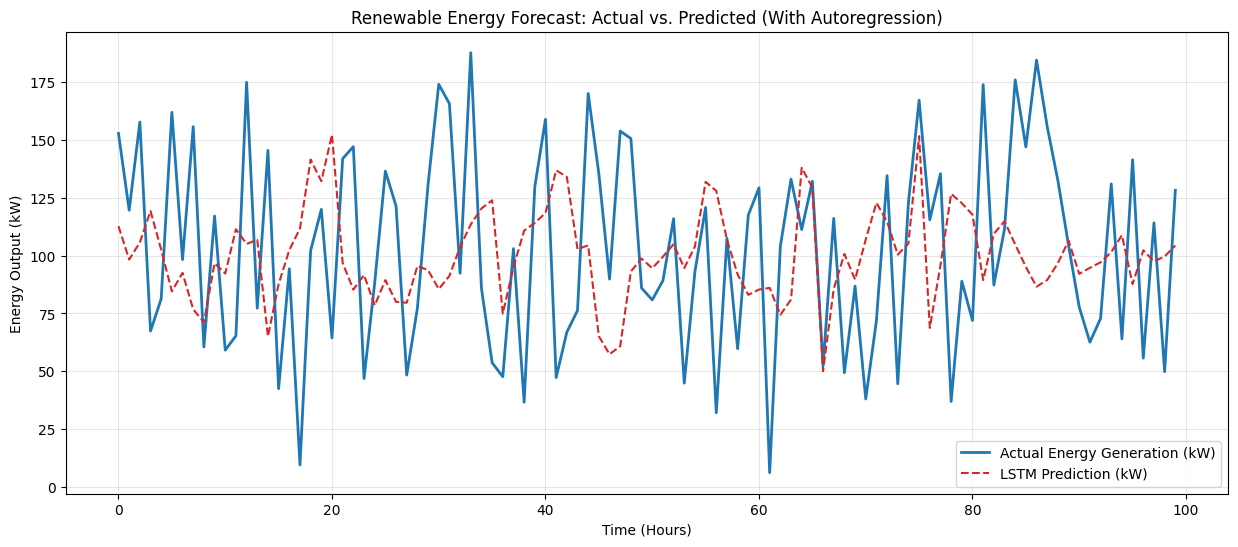

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Put model in evaluation mode
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

# 2. Hardcode the column count straight from the config so the Scaler is happy
# 7 features + 1 target = 8 columns total
num_total_cols = len(config['data']['features']) + 1 

dummy_preds = np.zeros((len(predictions), num_total_cols))
dummy_actuals = np.zeros((len(y_test), num_total_cols))

# Put our predictions and actuals into the very last column (index -1)
dummy_preds[:, -1] = predictions.flatten()
dummy_actuals[:, -1] = y_test.numpy().flatten()

# Perform the inverse transform
inv_predictions = loader.scaler.inverse_transform(dummy_preds)[:, -1]
inv_actuals = loader.scaler.inverse_transform(dummy_actuals)[:, -1]

# 3. Calculate Metrics
mae = mean_absolute_error(inv_actuals, inv_predictions)
rmse = np.sqrt(mean_squared_error(inv_actuals, inv_predictions))

print(f"📊 Final Model Performance (With Autoregression):")
print(f"Mean Absolute Error (MAE): {mae:.2f} kW")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} kW")

# 4. Plotting
plt.figure(figsize=(15, 6))
plt.plot(inv_actuals[:100], label='Actual Energy Generation (kW)', color='#1f77b4', linewidth=2)
plt.plot(inv_predictions[:100], label='LSTM Prediction (kW)', color='#d62728', linestyle='--')
plt.title('Renewable Energy Forecast: Actual vs. Predicted (With Autoregression)')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Output (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
import os
import joblib

# 1. Create output directories
os.makedirs("../outputs/models", exist_ok=True)
os.makedirs("../outputs/scalers", exist_ok=True)

# 2. Save the PyTorch Model Weights
model_path = "../outputs/models/microgrid_lstm_v1.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model weights saved to: {model_path}")

# 3. Save the Scikit-Learn Scaler (Crucial for inverse transforming future data!)
scaler_path = "../outputs/scalers/microgrid_scaler_v1.pkl"
joblib.dump(loader.scaler, scaler_path)
print(f"✅ Data Scaler saved to: {scaler_path}")

✅ Model weights saved to: ../outputs/models/microgrid_lstm_v1.pth
✅ Data Scaler saved to: ../outputs/scalers/microgrid_scaler_v1.pkl
